# Similitud entre celulares 


In [ ]:
gcloud auth application-default revoke

gcloud config get-value project

gcloud config get-value project

gcloud auth login

gcloud config set project meli-bi-data

gcloud config list

gcloud auth application-default login


In [ ]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install -q scikit-learn pandas numpy matplotlib rapidfuzz python-Levenshtein


import IPython, time
IPython.Application.instance().kernel.do_shutdown(restart=True)


{'status': 'ok', 'restart': True}

: 

In [2]:
# !pip install -q pandas numpy scikit-learn matplotlib rapidfuzz python-Levenshtein openai
import sys, os, math, re, json, time, random
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

try:
    from rapidfuzz import fuzz
except Exception:
    class _FauxFuzz:
        @staticmethod
        def ratio(a,b):
            return 100 if a==b else max(0, 100-len(set(a.split())^set(b.split()))*15)
    fuzz = _FauxFuzz()

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


In [ ]:

import google.auth
from google.cloud import bigquery

creds, project = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
client = bigquery.Client(project=project, credentials=creds)


client.query("SELECT 1 AS ok", location="US").result()
print("OK")


query = """
SELECT 1 AS ok
"""
job = client.query(query, location="US")  # <-- location acá
df = job.to_dataframe()

c:\Users\ctattoli\.cursor\.venv\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


OK


In [ ]:
from google.cloud import bigquery_storage

bqstorage_client = bigquery_storage.BigQueryReadClient()
df = job.to_dataframe(bqstorage_client=bqstorage_client)

In [ ]:
PROJECT    = "meli-bi-data"
LOCATION   = "US"
FULL_NAME  = "`meli-bi-data.WHOWNER.SBOX_SELLERSMP.CT_CELS_MLM`"  # tabla/vista fuente

OUT_DIR    = "./eda_outputs_cels"


In [ ]:

# =========================
# Imports y cliente BigQuery
# =========================
import os, warnings
os.makedirs(OUT_DIR, exist_ok=True)
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (10, 4), "axes.grid": True})

import google.auth
from google.cloud import bigquery

SCOPES = ["https://www.googleapis.com/auth/cloud-platform"]
creds, _ = google.auth.default(scopes=SCOPES)
bq = bigquery.Client(project=PROJECT, credentials=creds, location=LOCATION)

try:
    from google.cloud import bigquery_storage
    bqstorage_client = bigquery_storage.BigQueryReadClient(credentials=creds)
except Exception:
    bqstorage_client = None

print("✅ Cliente BigQuery listo. Proyecto de billing:", bq.project)


✅ Cliente BigQuery listo. Proyecto de billing: meli-bi-data


In [ ]:
# =========================
# Helpers
# =========================
from typing import List

def dry_run_bytes(sql: str, params=None) -> int:
    cfg = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False,
                                  query_parameters=params or [])
    job = bq.query(sql, job_config=cfg)
    return job.total_bytes_processed

def run_df(sql: str, params=None) -> pd.DataFrame:
    params = params or []
    print(f"Bytes (dry run): {dry_run_bytes(sql, params):,}")
    job_cfg = bigquery.QueryJobConfig(query_parameters=params)
    return bq.query(sql, job_config=job_cfg).to_dataframe(bqstorage_client=bqstorage_client)


1. REDUCCIÓN DE DIMENSIONALIDAD

In [55]:

SQL_BASE = f"""

  SELECT
    ITE_ITEM_ID,	ITE_ITEM_TITLE,	ITE_ITEM_CATALOG_PRODUCT_ID,	ITE_ITEM_CURRENT_PRICE,	MODEL,	ITEM_CONDITION,	BRAND,	RAM,	COLOR,	BATTERY_CAPACITY,	INTERNAL_MEMORY,	MAIN_FRONT_CAMERA_RESOLUTION,	MAIN_REAR_CAMERA_RESOLUTION,	QTY_VISITS
  FROM meli-bi-data.SBOX_SELLERSMP.CELS_MLM AS t
;
"""

_ = dry_run_bytes(SQL_BASE)
print(f"Dry-run bytes (pipeline base): {_:,}")


Dry-run bytes (pipeline base): 10,795,819


In [ ]:
import math

def n_for_prop(p=0.05, eps=0.0025, z=2.58, N=69951, deff=1.0):
    """Tamaño muestral para una proporción con (opcional) corrección por población finita y design effect."""
    n0 = (z**2 * p * (1-p)) / (eps**2)     # Cochran (población infinita)
    n0 *= deff                             # efecto de diseño
    if not N:                              # sin FPC
        return math.ceil(n0)
    n = n0 / (1 + (n0 - 1) / N)            # FPC
    return math.ceil(n)

# Ejemplos
print("n0 infinita:", n_for_prop(0.05, 0.0025, 2.58))
print("N con FPC:", n_for_prop(0.05, 0.0025, 2.58, N=69_951))
print("N + diseño (DEFF=1.2):", n_for_prop(0.05, 0.0025, 2.58, N=69_951, deff=1.2))


n0 infinita: 29358
N con FPC: 29358
N + diseño (DEFF=1.2): 32502


In [ ]:
#REDUCCIÓN DE DIMENSIONALIDAD

PROJECT   = "meli-bi-data"
LOCATION  = "US"
TABLE_FULL = "`meli-bi-data.SBOX_SELLERSMP.CELS_MLM`"  # ajustá si tu ruta es distinta

PCT_USERS  = 70             

USE_TABLESAMPLE   = True    
TABLESAMPLE_PCT   = 70    
TABLESAMPLE_SEED  = 42    

# =========================
# Cliente y helpers
# =========================
import google.auth
from google.cloud import bigquery
import pandas as pd
from pathlib import Path

SCOPES = ["https://www.googleapis.com/auth/cloud-platform"]
creds, _ = google.auth.default(scopes=SCOPES)
client = bigquery.Client(project=PROJECT, credentials=creds, location=LOCATION)

try:
    from google.cloud import bigquery_storage
    bqstorage_client = bigquery_storage.BigQueryReadClient(credentials=creds)
except Exception:
    bqstorage_client = None

def human_bytes(n):
    for unit in ["B","KB","MB","GB","TB"]:
        if n < 1024: return f"{n:.2f} {unit}"
        n /= 1024
    return f"{n:.2f} PB"


TABLESAMPLE_CLAUSE = (
    f"TABLESAMPLE SYSTEM ({TABLESAMPLE_PCT} PERCENT) "
    if USE_TABLESAMPLE else ""
)

SQL = f"""
WITH sampled AS (
  SELECT *
  FROM {TABLE_FULL}
  {TABLESAMPLE_CLAUSE}
),
base AS (
  SELECT
    ITE_ITEM_ID,	ITE_ITEM_TITLE,	ITE_ITEM_CATALOG_PRODUCT_ID,	ITE_ITEM_CURRENT_PRICE,	MODEL,	ITEM_CONDITION,	BRAND,	RAM,	COLOR,	BATTERY_CAPACITY,	INTERNAL_MEMORY,	MAIN_FRONT_CAMERA_RESOLUTION,	MAIN_REAR_CAMERA_RESOLUTION,	QTY_VISITS
  FROM sampled AS t
  WHERE 
    -- Muestreo estable por usuario (preserva balance T/C y es reproducible)
    MOD(ABS(FARM_FINGERPRINT(CAST(t.ITE_ITEM_ID AS STRING))), 100) < @pct
)
SELECT *
FROM base
"""

params = [

    bigquery.ScalarQueryParameter("pct","INT64",       PCT_USERS),
]

# =========================
# Dry run de bytes
# =========================
dry_cfg = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False, query_parameters=params)
dry_job = client.query(SQL, job_config=dry_cfg)
print("Dry-run:", human_bytes(dry_job.total_bytes_processed))


df = client.query(SQL, job_config=bigquery.QueryJobConfig(query_parameters=params)).to_dataframe(
        bqstorage_client=bqstorage_client
)
print("Shape DF:", df.shape)




Dry-run: 10.30 MB
Shape DF: (48859, 14)


2. TESTS DE REPRESENTATIVIDAD

In [ ]:
# =========================
#TEST DE REPRESENTATIVIDAD 
# =========================
import numpy as np
import pandas as pd
import re, warnings, os


from scipy import stats
from scipy.spatial.distance import jensenshannon


if 'df' not in globals():
    raise NameError("No encontré 'df'. Asegurate de tener tu muestra en una variable llamada df.")
SAMPLE = df.copy()


POP_BASE = globals().get('df_pop', None) or globals().get('df_bq', None)


if POP_BASE is None and ('TABLE_FULL' in globals()):
    try:
        from google.cloud import bigquery
        import google.auth
        PROJECT  = globals().get('PROJECT', os.getenv('BQ_PROJECT', 'meli-bi-data'))
        LOCATION = globals().get('LOCATION', os.getenv('BQ_LOCATION', 'US'))
        SCOPES = ["https://www.googleapis.com/auth/cloud-platform"]
        creds, _ = google.auth.default(scopes=SCOPES)
        bq_client = bigquery.Client(project=PROJECT, credentials=creds, location=LOCATION)

     
        SQL_POP = f"""
        SELECT
          ITE_ITEM_ID, ITE_ITEM_TITLE, ITE_ITEM_CATALOG_PRODUCT_ID, ITE_ITEM_CURRENT_PRICE,
          MODEL, ITEM_CONDITION, BRAND, RAM, COLOR, BATTERY_CAPACITY, INTERNAL_MEMORY,
          MAIN_FRONT_CAMERA_RESOLUTION, MAIN_REAR_CAMERA_RESOLUTION, QTY_VISITS
        FROM {TABLE_FULL}
        """

        try:
            dry = bq_client.query(SQL_POP, job_config=bigquery.QueryJobConfig(dry_run=True, use_query_cache=True))
            print(f"POP BigQuery dry-run bytes: {dry.total_bytes_processed:,}")
        except Exception:
            pass

        POP_BASE = bq_client.query(SQL_POP).to_dataframe()
        print("POP obtenido desde BigQuery:", POP_BASE.shape)
    except Exception as e:
        print("⚠️ No pude traer POP desde BigQuery:", e)


if POP_BASE is None:
    print("⚠️ Fallback: usando POP = SAMPLE (los tests darán match perfecto; solo útil para debug).")
    POP_BASE = SAMPLE.copy()

print("SAMPLE shape:", SAMPLE.shape, "| POP shape:", POP_BASE.shape)


colmap = {
    'ITE_ITEM_ID':                  'ITE_ITEM_ID',
    'ITE_ITEM_TITLE':               'ITE_ITEM_TITLE',
    'ITE_ITEM_CATALOG_PRODUCT_ID':  'ITE_ITEM_CATALOG_PRODUCT_ID',
    'ITE_ITEM_CURRENT_PRICE':       'ITE_ITEM_CURRENT_PRICE',
    'MODEL':                        'MODEL',
    'ITEM_CONDITION':               'ITEM_CONDITION',
    'BRAND':                        'BRAND',
    'RAM':                          'RAM',
    'COLOR':                        'COLOR',
    'BATTERY_CAPACITY':             'BATTERY_CAPACITY',
    'INTERNAL_MEMORY':              'INTERNAL_MEMORY',
    'MAIN_FRONT_CAMERA_RESOLUTION': 'MAIN_FRONT_CAMERA_RESOLUTION',
    'MAIN_REAR_CAMERA_RESOLUTION':  'MAIN_REAR_CAMERA_RESOLUTION',
    'QTY_VISITS':                   'QTY_VISITS',
}

def parse_gb(x):
    if pd.isna(x): return np.nan
    m = re.search(r'(\d{1,4})\s*gb', str(x).lower())
    return int(m.group(1)) if m else pd.to_numeric(x, errors='coerce')

def apply_colmap(df_in: pd.DataFrame, colmap: dict) -> pd.DataFrame:
    df_out = df_in.copy()
   
    rename_dict = {real: canon for canon, real in colmap.items() if real in df_out.columns and real != canon}
    if rename_dict:
        df_out = df_out.rename(columns=rename_dict)
 
    for canon in colmap.keys():
        if canon not in df_out.columns:
            df_out[canon] = np.nan
    
    df_out['ITE_ITEM_CURRENT_PRICE'] = pd.to_numeric(df_out['ITE_ITEM_CURRENT_PRICE'], errors='coerce')
    df_out['QTY_VISITS'] = pd.to_numeric(df_out['QTY_VISITS'], errors='coerce')
    
    df_out['RAM_GB'] = df_out['RAM'].apply(parse_gb)
    df_out['INTERNAL_MEMORY_GB'] = df_out['INTERNAL_MEMORY'].apply(parse_gb)
    return df_out

POP = apply_colmap(POP_BASE, colmap)
SAMPLE = apply_colmap(SAMPLE, colmap)


NUMERIC_COLS = [c for c in ['ITE_ITEM_CURRENT_PRICE','QTY_VISITS'] if c in POP.columns and c in SAMPLE.columns]
CATEG_COLS   = [c for c in ['BRAND','ITEM_CONDITION','COLOR','MODEL'] if c in POP.columns and c in SAMPLE.columns]
if not NUMERIC_COLS and not CATEG_COLS:
    raise ValueError("No hay columnas compatibles entre POP y SAMPLE para testear.")


def standardized_mean_diff(pop, samp):
    pop = np.asarray(pop, dtype=float); samp = np.asarray(samp, dtype=float)
    mu_p, mu_s = np.nanmean(pop), np.nanmean(samp)
    s_p, s_s = np.nanstd(pop, ddof=1), np.nanstd(samp, ddof=1)
    s_pooled = np.sqrt(((s_p**2)+(s_s**2))/2)
    if s_pooled == 0 or np.isnan(s_pooled): return 0.0
    return (mu_s - mu_p) / s_pooled

def js_divergence(pop_counts: dict, samp_counts: dict):
    keys = sorted(set(pop_counts.keys()) | set(samp_counts.keys()))
    p = np.array([pop_counts.get(k,0) for k in keys], dtype=float)
    q = np.array([samp_counts.get(k,0) for k in keys], dtype=float)
    if p.sum()==0 or q.sum()==0: return np.nan
    p /= p.sum(); q /= q.sum()
    return float(jensenshannon(p, q)**2)  # distancia^2 = divergencia

def compare_distributions(POP: pd.DataFrame, SAMPLE: pd.DataFrame):
    rows = []
    # Numericos: KS, t-test, SMD
    for col in NUMERIC_COLS:
        p = pd.to_numeric(POP[col], errors='coerce').dropna()
        s = pd.to_numeric(SAMPLE[col], errors='coerce').dropna()
        if len(p)>2 and len(s)>2:
            # KS compatible con SciPy nuevas/viejas
            try:
                ks = stats.ks_2samp(p, s, alternative='two-sided', method='auto')
            except TypeError:
                ks = stats.ks_2samp(p, s, alternative='two-sided')
            tt = stats.ttest_ind(p, s, equal_var=False, nan_policy='omit')
            smd = standardized_mean_diff(p, s)
            rows.append({'feature':col,'type':'numeric','n_pop':len(p),'n_samp':len(s),
                         'ks_stat':round(ks.statistic,4),'ks_p':round(ks.pvalue,4),
                         't_stat':round(tt.statistic,4),'t_p':round(tt.pvalue,4),
                         'smd':round(smd,4)})
        else:
            rows.append({'feature':col,'type':'numeric','n_pop':len(p),'n_samp':len(s),
                         'ks_stat':None,'ks_p':None,'t_stat':None,'t_p':None,'smd':None})
    # Categóricos: Chi2 + JS
    for col in CATEG_COLS:
        p_counts = POP[col].fillna('NA').astype(str).value_counts().to_dict()
        s_counts = SAMPLE[col].fillna('NA').astype(str).value_counts().to_dict()
        cats = sorted(set(p_counts.keys()) | set(s_counts.keys()))
        p_obs = np.array([p_counts.get(c,0) for c in cats], dtype=float)
        s_obs = np.array([s_counts.get(c,0) for c in cats], dtype=float)
        if p_obs.sum()==0 or s_obs.sum()==0:
            chi2_stat = chi2_p = None
        else:
            expected = (p_obs / p_obs.sum()) * s_obs.sum()
            with np.errstate(divide='ignore', invalid='ignore'):
                chi2 = stats.chisquare(s_obs, f_exp=expected)
            chi2_stat = None if np.isnan(chi2.statistic) else float(chi2.statistic)
            chi2_p    = None if np.isnan(chi2.pvalue)   else float(chi2.pvalue)
        jsd = js_divergence(p_counts, s_counts)
        rows.append({'feature':col,'type':'categorical','n_categories':len(cats),
                     'chi2_stat':None if chi2_stat is None else round(chi2_stat,4),
                     'chi2_p':None if chi2_p is None else round(chi2_p,4),
                     'js_divergence':None if (jsd is None or np.isnan(jsd)) else round(jsd,6)})
    return pd.DataFrame(rows)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    TESTS = compare_distributions(POP, SAMPLE)

print("Resumen (p>0.05 ⇒ sin diferencias significativas; SMD<0.1 ⇒ diferencia pequeña)")
try:
    display(TESTS.sort_values(['type','feature']).reset_index(drop=True))
except Exception:
    print(TESTS.sort_values(['type','feature']).reset_index(drop=True).to_string(index=False))

    


POP BigQuery dry-run bytes: 10,795,819
POP obtenido desde BigQuery: (69951, 14)
SAMPLE shape: (48859, 14) | POP shape: (69951, 14)
Resumen (p>0.05 ⇒ sin diferencias significativas; SMD<0.1 ⇒ diferencia pequeña)


,feature,type,n_pop,n_samp,ks_stat,ks_p,t_stat,t_p,smd,n_categories,chi2_stat,chi2_p,js_divergence
0,BRAND,categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1595.0,481.3005,1.0000,0.002361
1,COLOR,categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012.0,313.5427,1.0000,0.001409
2,ITEM_CONDITION,categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.1782,0.9963,0.000000
3,MODEL,categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9622.0,2842.5578,1.0000,0.013520
4,ITE_ITEM_CURRENT_PRICE,numeric,69951.0,48859.0,0.0018,1.0,-0.0108,0.9914,0.0001,NaN,NaN,NaN,NaN
5,QTY_VISITS,numeric,69951.0,48859.0,0.0017,1.0,-0.7467,0.4552,0.0044,NaN,NaN,NaN,NaN


In [ ]:
#SMR
import numpy as np, pandas as pd


NUMERIC_COLS = [c for c in ['ITE_ITEM_CURRENT_PRICE','QTY_VISITS'] if c in POP.columns and c in SAMPLE.columns]
CATEG_COLS   = [c for c in ['BRAND','ITEM_CONDITION','COLOR','MODEL'] if c in POP.columns and c in SAMPLE.columns]

def smr_numeric(POP, SAMPLE, cols):
    rows=[]
    for c in cols:
        p = pd.to_numeric(POP[c], errors='coerce').dropna()
        s = pd.to_numeric(SAMPLE[c], errors='coerce').dropna()
        if len(p)==0 or len(s)==0: 
            rows.append({'feature':c,'mu_pop':np.nan,'mu_samp':np.nan,'smr_mean':np.nan})
            continue
        mu_p, mu_s = p.mean(), s.mean()
        smr = (mu_s / mu_p) if mu_p not in [0, np.nan] else np.nan
        rows.append({'feature':c, 'mu_pop':mu_p, 'mu_samp':mu_s, 'smr_mean':smr})
    return pd.DataFrame(rows)

def smr_categorical(POP, SAMPLE, cols, eps=1e-9, topk=15):
    details_top = []
    summaries   = []
    for c in cols:
        
        p_counts = POP[c].fillna('NA').astype(str).value_counts()
        s_counts = SAMPLE[c].fillna('NA').astype(str).value_counts()
        cats = sorted(set(p_counts.index) | set(s_counts.index))
        P = p_counts.reindex(cats, fill_value=0).astype(float)
        S = s_counts.reindex(cats, fill_value=0).astype(float)
      
        Pp = (P + eps) / (P.sum() + eps*len(cats))
        Sp = (S + eps) / (S.sum() + eps*len(cats))
        ratio = Sp / Pp
        abs_pp_diff = (Sp - Pp).abs()
        abs_log_ratio = np.abs(np.log(ratio))

        df_all = pd.DataFrame({
            'feature': c,
            'category': cats,
            'pop_prop': Pp.values,
            'samp_prop': Sp.values,
            'ratio': ratio.values,
            'abs_pp_diff': abs_pp_diff.values,
            'abs_log_ratio': abs_log_ratio
        })
     
        summaries.append({
            'feature': c,
            'mean_abs_pp_diff_w': float((df_all['abs_pp_diff'] * df_all['pop_prop']).sum()),  # promedio ponderado por pop
            'max_abs_pp_diff': float(df_all['abs_pp_diff'].max()),
            'mean_abs_log_ratio_w': float((df_all['abs_log_ratio'] * df_all['pop_prop']).sum()),
            'max_ratio': float(df_all['ratio'].max()),
            'min_ratio': float(df_all['ratio'].min()),
            'top_category': df_all.sort_values('abs_log_ratio', ascending=False).iloc[0]['category']
        })
       
        details_top.append(df_all.sort_values('abs_log_ratio', ascending=False).head(topk))

    SMR_CAT_TOP = pd.concat(details_top, ignore_index=True) if details_top else pd.DataFrame()
    SMR_CAT_SUMMARY = pd.DataFrame(summaries)
    return SMR_CAT_TOP, SMR_CAT_SUMMARY


SMR_NUM = smr_numeric(POP, SAMPLE, NUMERIC_COLS)
SMR_CAT_TOP, SMR_CAT_SUMMARY = smr_categorical(POP, SAMPLE, CATEG_COLS, eps=1e-9, topk=15)

print("SMR numéricos (mean_samp / mean_pop):")
display(SMR_NUM)

print("Resumen SMR categóricos (valores cercanos a 1/0 indican buena representación):")
display(SMR_CAT_SUMMARY.sort_values('feature'))

print("Top categorías con mayor desvío (para revisión):")
display(SMR_CAT_TOP.head(30))


SMR numéricos (mean_samp / mean_pop):


,feature,mu_pop,mu_samp,smr_mean
0,ITE_ITEM_CURRENT_PRICE,4782.423612,4783.119208,1.000145
1,QTY_VISITS,1112.476662,1156.478499,1.039553


Resumen SMR categóricos (valores cercanos a 1/0 indican buena representación):


,feature,mean_abs_pp_diff_w,max_abs_pp_diff,mean_abs_log_ratio_w,max_ratio,min_ratio,top_category
0,BRAND,0.000324,0.001176,0.131765,1.431691,3.579228e-10,Pepe
2,COLOR,0.000560,0.000925,0.075327,1.431691,7.158456e-10,Peach fuzz
1,ITEM_CONDITION,0.000187,0.000380,0.000759,1.007846,9.544608e-01,NA
3,MODEL,0.000114,0.000910,0.688912,1.431691,2.386152e-10,Y1000


Top categorías con mayor desvío (para revisión):


,feature,category,pop_prop,samp_prop,ratio,abs_pp_diff,abs_log_ratio
0,BRAND,Pepe,0.000057,2.046706e-14,3.579228e-10,0.000057,21.750704
1,BRAND,Mitsui mc32020,0.000043,2.046706e-14,4.772304e-10,0.000043,21.463022
2,BRAND,Boombox Electronics,0.000043,2.046706e-14,4.772304e-10,0.000043,21.463022
3,BRAND,NewlyGeneral,0.000029,2.046706e-14,7.158456e-10,0.000029,21.057557
4,BRAND,ML-NLEADER,0.000029,2.046706e-14,7.158456e-10,0.000029,21.057557
5,BRAND,Oppo Reno9,0.000029,2.046706e-14,7.158456e-10,0.000029,21.057557
6,BRAND,Star,0.000029,2.046706e-14,7.158456e-10,0.000029,21.057557
7,BRAND,iPro,0.000029,2.046706e-14,7.158456e-10,0.000029,21.057557
8,BRAND,Zerone,0.000029,2.046706e-14,7.158456e-10,0.000029,21.057557
9,BRAND,Powtech,0.000029,2.046706e-14,7.158456e-10,0.000029,21.057557


In [ ]:
## SMR AJUSTADO

MIN_POP_PROP = 0.001

def smr_categorical_thresholded(POP, SAMPLE, cols, min_pop_prop=MIN_POP_PROP, eps=1e-9, topk=15):
    import numpy as np, pandas as pd
    details_top, summaries = [], []
    for c in cols:
        p_counts = POP[c].fillna('NA').astype(str).value_counts()
        s_counts = SAMPLE[c].fillna('NA').astype(str).value_counts()
        cats = sorted(set(p_counts.index) | set(s_counts.index))
        P = p_counts.reindex(cats, fill_value=0).astype(float)
        S = s_counts.reindex(cats, fill_value=0).astype(float)

        # proporciones + smoothing
        Pp = (P + eps) / (P.sum() + eps*len(cats))
        Sp = (S + eps) / (S.sum() + eps*len(cats))

        df_all = pd.DataFrame({'feature': c, 'category': cats, 'pop_prop': Pp, 'samp_prop': Sp})
        df_all = df_all[df_all['pop_prop'] >= min_pop_prop].copy()  # <-- filtra colas
        if df_all.empty:
            continue

        df_all['ratio'] = df_all['samp_prop'] / df_all['pop_prop']
        df_all['abs_pp_diff'] = (df_all['samp_prop'] - df_all['pop_prop']).abs()
        df_all['abs_log_ratio'] = np.abs(np.log(df_all['ratio']))

        summaries.append({
            'feature': c,
            'coverage_pop': float(df_all['pop_prop'].sum()),  # masa cubierta tras el filtro
            'mean_abs_pp_diff_w': float((df_all['abs_pp_diff'] * df_all['pop_prop']).sum()),
            'max_abs_pp_diff': float(df_all['abs_pp_diff'].max()),
            'mean_abs_log_ratio_w': float((df_all['abs_log_ratio'] * df_all['pop_prop']).sum()),
            'max_ratio': float(df_all['ratio'].max()),
            'min_ratio': float(df_all['ratio'].min()),
            'top_category': df_all.sort_values('abs_log_ratio', ascending=False).iloc[0]['category']
        })
        details_top.append(df_all.sort_values('abs_log_ratio', ascending=False).head(topk))

    SMR_CAT_SUMMARY_T = pd.DataFrame(summaries)
    SMR_CAT_TOP_T = pd.concat(details_top, ignore_index=True) if details_top else pd.DataFrame()
    return SMR_CAT_TOP_T, SMR_CAT_SUMMARY_T

SMR_CAT_TOP_T, SMR_CAT_SUMMARY_T = smr_categorical_thresholded(POP, SAMPLE, ['BRAND','ITEM_CONDITION','COLOR','MODEL'])

display(SMR_CAT_SUMMARY_T.sort_values('feature'))


,feature,coverage_pop,mean_abs_pp_diff_w,max_abs_pp_diff,mean_abs_log_ratio_w,max_ratio,min_ratio,top_category
0,BRAND,0.924547,0.000322,0.001176,0.011939,1.099076,0.935372,Umidigi
2,COLOR,0.941716,0.000558,0.000925,0.008028,1.134340,0.936620,Black
1,ITEM_CONDITION,0.999914,0.000187,0.000380,0.000755,1.007846,0.992902,Reacondicionado
3,MODEL,0.527369,0.000101,0.000910,0.011932,1.120454,0.859015,I17pro


In [ ]:
## TAMAÑO DEL EFECTO CREAMERS V
import numpy as np, pandas as pd
from scipy.stats import chi2_contingency

def cramers_v_from_counts(p_counts, s_counts):
    cats = sorted(set(p_counts) | set(s_counts))
    p_obs = np.array([p_counts.get(c,0) for c in cats], dtype=float)
    s_obs = np.array([s_counts.get(c,0) for c in cats], dtype=float)
    n = s_obs.sum()
    if n == 0: return np.nan
    expected = (p_obs / p_obs.sum()) * n
    chi2 = ((s_obs - expected)**2 / np.where(expected==0, 1, expected)).sum()
    k = len(cats)
    V = np.sqrt(chi2 / (n * (k-1))) if k > 1 else 0.0
    return V

out = []
for col in ['BRAND','COLOR','ITEM_CONDITION','MODEL']:
    p_counts = POP[col].fillna('NA').astype(str).value_counts().to_dict()
    s_counts = SAMPLE[col].fillna('NA').astype(str).value_counts().to_dict()
    V = cramers_v_from_counts(p_counts, s_counts)
    out.append({'feature':col, 'cramers_v': round(float(V), 4)})
pd.DataFrame(out)


,feature,cramers_v
0,BRAND,0.0025
1,COLOR,0.0025
2,ITEM_CONDITION,0.0010
3,MODEL,0.0025


3. RESUMEN ESTADISTICO

In [ ]:

def numeric_summary(col):
    p = pd.to_numeric(POP[col], errors='coerce')
    s = pd.to_numeric(SAMPLE[col], errors='coerce')
    return pd.DataFrame({
        'feature':[col],
        'pop_mean':[p.mean()], 'samp_mean':[s.mean()], 'diff_mean':[s.mean()-p.mean()],
        'pop_median':[p.median()], 'samp_median':[s.median()], 'diff_median':[s.median()-p.median()],
        'pop_std':[p.std()], 'samp_std':[s.std()]
    })

pd.concat([numeric_summary('ITE_ITEM_CURRENT_PRICE'),
           numeric_summary('QTY_VISITS')], ignore_index=True)


,feature,pop_mean,samp_mean,diff_mean,pop_median,samp_median,diff_median,pop_std,samp_std
0,ITE_ITEM_CURRENT_PRICE,4782.423612,4783.119208,0.695595,2988.8,2988.8,0.0,10789.820496,10946.408372
1,QTY_VISITS,1112.476662,1156.478499,44.001837,23.0,23.0,0.0,9583.340493,10272.284169


4. FEATURE ENGINEERING + KNN

In [ ]:
# ======================================
# SIMILITUD DE CELULARES CODIGO FINAL!!
# ======================================

import re, warnings, math, numpy as np, pandas as pd, time
from IPython.display import display
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


TOP_ANCHORS = 30          
TOP_K = 3               
TEXT_WEIGHT, CAT_WEIGHT, NUM_WEIGHT = 0.55, 0.25, 0.20
LEAF_WEIGHT = 0.30        # peso de hojas RF si las usás
MAX_TEXT_FEATURES = 8000


ALPHA, BETA = 0.85, 0.15

WEIGHTS_BONUS = {
    'os_match': 1.0,
    'series_match': 1.0,
    'storage_bin': 0.8,
    'ram_bin': 0.6,
    'tier_penalty': 0.6,  
    'high_end_match': 0.6,
    'color_closeness': 0.4
}

LGB_PARAMS = dict(
    n_estimators=20,         # arbolitos
    num_leaves=16,           # hojas por árbol
    min_child_samples=100,   # datos por hoja
    feature_fraction_bynode=0.2,
    boosting_type='rf',
    subsample=(1.0 - 1.0/np.e),
    subsample_freq=1,
    feature_fraction=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)


def normalize_text(s):
    if pd.isna(s): return ''
    s = str(s).lower()
    s = re.sub(r"[\-_/]+"," ", s)
    s = re.sub(r"[^a-z0-9áéíóúñü\s]", "", s)
    s = re.sub(r"\s+"," ", s).strip()
    return s

COLOR_MAP = {
    'negro':  ['negro','black','grafito','graphite','space gray','gris oscuro','midnight'],
    'gris':   ['gris','silver','plateado','titanium','titanio','natural','graphite','space gray'],
    'blanco': ['blanco','white'],
    'azul':   ['azul','blue','cian'],
    'rojo':   ['rojo','red'],
    'verde':  ['verde','green'],
}
def map_color(c):
    c0 = normalize_text(c)
    if not c0: return np.nan
    for base, alts in COLOR_MAP.items():
        if c0 == base or any(a in c0 for a in alts):
            return base
    return c0

HIGH_END_BRANDS = {'apple','samsung'}
HIGH_END_MODELS_HINTS = {'pro','ultra','s2','s23','s24','s25','max','promax','pro max','plus'}
def is_high_end(brand, model):
    b = (brand or '').lower(); m = (model or '').lower()
    if b in HIGH_END_BRANDS: return 1
    return int(any(h in m for h in HIGH_END_MODELS_HINTS))

def parse_gb(x):
    if pd.isna(x): return np.nan
    m = re.search(r"(\d{1,4})\s*gb", str(x).lower())
    return int(m.group(1)) if m else pd.to_numeric(x, errors='coerce')

def extract_storage_from_title(title):
    t = normalize_text(title)
    m = re.search(r"(\d{2,4})\s?gb", t)
    return int(m.group(1)) if m else np.nan

def extract_ram_from_title(title):
    t = normalize_text(title)
    m = re.search(r"(\d{1,2})\s*gb\s*ram", t) or re.search(r"ram\s*(\d{1,2})\s*gb", t)
    return int(m.group(1)) if m else np.nan

def parse_mah(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    m = re.search(r"(\d{3,5})\s*m?ah", s) or re.search(r"(\d{3,5})", s)
    return int(m.group(1)) if m else pd.to_numeric(x, errors='coerce')

def parse_mp(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    m = re.search(r"(\d{1,3}(?:\.\d)?)\s*mp", s) or re.search(r"(\d{1,3}(?:\.\d)?)", s)
    try:
        return float(m.group(1)) if m else pd.to_numeric(x, errors='coerce')
    except Exception:
        return pd.to_numeric(x, errors='coerce')

def _col(df: pd.DataFrame, name: str):
    return df[name] if name in df.columns else pd.Series([np.nan]*len(df), index=df.index)

# --------------- FEATURES BASE  ---------------
def prepare_features(df_in: pd.DataFrame) -> pd.DataFrame:
    d = pd.DataFrame(index=df_in.index)
    d['item_id']   = _col(df_in, 'ITE_ITEM_ID')
    d['title']     = _col(df_in, 'ITE_ITEM_TITLE')
    d['brand']     = _col(df_in, 'BRAND').astype(str).str.strip().str.title()
    d['model']     = _col(df_in, 'MODEL').astype(str).str.strip()
    d['color']     = _col(df_in, 'COLOR')
    d['condition'] = _col(df_in, 'ITEM_CONDITION')
    d['price_mxn'] = pd.to_numeric(_col(df_in, 'ITE_ITEM_CURRENT_PRICE'), errors='coerce')
    d['visits']    = pd.to_numeric(_col(df_in, 'QTY_VISITS'), errors='coerce')

    d['storage_gb'] = _col(df_in, 'INTERNAL_MEMORY').apply(parse_gb)
    d['ram_gb']     = _col(df_in, 'RAM').apply(parse_gb)
    ms = d['storage_gb'].isna()
    if ms.any(): d.loc[ms, 'storage_gb'] = _col(df_in, 'ITE_ITEM_TITLE').apply(extract_storage_from_title)[ms]
    mr = d['ram_gb'].isna()
    if mr.any(): d.loc[mr, 'ram_gb']     = _col(df_in, 'ITE_ITEM_TITLE').apply(extract_ram_from_title)[mr]

    d['battery_mah'] = _col(df_in, 'BATTERY_CAPACITY').apply(parse_mah)
    d['front_mp']    = _col(df_in, 'MAIN_FRONT_CAMERA_RESOLUTION').apply(parse_mp)
    d['rear_mp']     = _col(df_in, 'MAIN_REAR_CAMERA_RESOLUTION').apply(parse_mp)

    d['title_norm']  = d['title'].fillna('').apply(normalize_text)
    d['text']        = (d['title_norm'] + ' ' + d['brand'].fillna('').str.lower() + ' ' + d['model'].fillna('').str.lower()).str.strip()
    if d['text'].str.strip().eq('').all():
        d['text'] = (d['brand'].fillna('') + ' ' + d['model'].fillna('') + ' ' + d['title_norm']).str.strip()

    d['color_norm']  = d['color'].apply(map_color)
    d['is_high_end'] = [is_high_end(b, m) for b, m in zip(d['brand'], d['model'])]
    d['brand_tier']  = np.select(
        [d['brand'].str.lower().isin(['apple']),
         d['brand'].str.lower().isin(['samsung','google','oneplus'])],
        [3, 2], default=1
    )

    d['log_price']    = np.log1p(d['price_mxn'])
    d['price_per_gb'] = (d['price_mxn'] / d['storage_gb']).replace([np.inf, -np.inf], np.nan)

    if d['visits'].isna().all():
        d['visits'] = np.random.randint(10_000, 100_000, size=len(d))

    return d.reset_index(drop=True)

# --------------- FEATURES EXTRA  ---------------
def _txt(df):
    return (df['title'].fillna('') + ' ' + df['model'].fillna('')).str.lower()

def _parse_inches(s):
    if pd.isna(s): return np.nan
    s = str(s)
    m = re.search(r'(\d{1,2}(?:[.,]\d)?)\s*(?:pulg|pulgadas|")', s)
    return float(m.group(1).replace(',', '.')) if m else np.nan

def _parse_hz(s):
    if pd.isna(s): return np.nan
    m = re.search(r'(\d{2,3})\s*hz', str(s))
    return float(m.group(1)) if m else np.nan

def _disp_type(s):
    if pd.isna(s): return np.nan
    s = str(s)
    if 'amoled' in s or 'super amoled' in s or 'oled' in s: return 'oled'
    if 'ips' in s: return 'ips'
    if 'lcd' in s: return 'lcd'
    return np.nan

def _port_type(s):
    if pd.isna(s): return np.nan
    s = str(s)
    if 'usb c' in s or 'usb-c' in s or 'type c' in s or 'type-c' in s: return 'usb-c'
    if 'lightning' in s: return 'lightning'
    if 'micro usb' in s or 'micro-usb' in s: return 'micro-usb'
    return np.nan

def _parse_ip_tier(s):
    if pd.isna(s): return np.nan
    s = str(s)
    m = re.search(r'\bip(6[0-9])\b', s)
    if not m: return np.nan
    code = int(m.group(1))
    return {65:0.5, 66:0.75, 67:1.0, 68:2.0}.get(code, np.nan)

def _parse_watts(s):
    if pd.isna(s): return np.nan
    m = re.search(r'(\d{2,3})\s*w', str(s))
    return float(m.group(1)) if m else np.nan

def _parse_series(s):
    if pd.isna(s): return (np.nan, np.nan, np.nan)
    s = str(s)
    if 'iphone' in s:
        v = 'pro max' if 'pro max' in s else ('pro' if 'pro' in s else ('plus' if 'plus' in s else ('mini' if 'mini' in s else np.nan)))
        m = re.search(r'iphone\s*(se|1[0-9]|[6-9])', s)
        gen = m.group(1) if m else np.nan
        return ('iphone', gen, v)
    if 'galaxy' in s and ' s' in s:
        m = re.search(r'galaxy\s*s\s*([0-9]{1,2})', s)
        gen = m.group(1) if m else np.nan
        v = 'ultra' if 'ultra' in s else ('plus' if 'plus' in s else np.nan)
        return ('galaxy-s', gen, v)
    if 'galaxy' in s and ' a' in s:
        m = re.search(r'galaxy\s*a\s*([0-9]{1,2})', s)
        gen = m.group(1) if m else np.nan
        return ('galaxy-a', gen, np.nan)
    if 'redmi note' in s:
        m = re.search(r'redmi note\s*([0-9]{1,2})', s)
        gen = m.group(1) if m else np.nan
        return ('redmi-note', gen, np.nan)
    if 'poco' in s:
        m = re.search(r'poco\s*([a-z]?\d{1,2})', s)
        gen = m.group(1) if m else np.nan
        return ('poco', gen, np.nan)
    if 'moto g' in s:
        m = re.search(r'moto g\s*([0-9]{1,2})', s)
        gen = m.group(1) if m else np.nan
        return ('moto-g', gen, np.nan)
    return (np.nan, np.nan, np.nan)

def _parse_soc(s):
    if pd.isna(s): return (np.nan, np.nan)
    s = str(s)
    if 'bionic' in s or re.search(r'\ba\d{2}\b', s):
        m = re.search(r'\ba\s?(\d{2})\b', s); ver = int(m.group(1)) if m else 0
        tier = 3 if ver >= 16 else (2 if ver >= 13 else 1)
        return ('apple-a', tier)
    if 'snapdragon' in s:
        if re.search(r'8\s*gen|8\d{2}', s): return ('snapdragon', 3)
        if re.search(r'7\s*gen|7\d{2}', s): return ('snapdragon', 2)
        if re.search(r'6\d{2}|4\d{2}', s):  return ('snapdragon', 1)
        return ('snapdragon', 2)
    if 'dimensity' in s:
        m = re.search(r'dimensity\s*(\d{3,4})', s); n = int(m.group(1)) if m else 0
        tier = 3 if n >= 9000 else (2 if n >= 8000 or n >= 700 else 1)
        return ('dimensity', tier)
    if 'exynos' in s:
        m = re.search(r'exynos\s*(\d{3,4})', s); n = int(m.group(1)) if m else 0
        tier = 3 if n >= 2200 else (2 if n >= 1280 else 1)
        return ('exynos', tier)
    if 'kirin' in s:
        m = re.search(r'kirin\s*(\d{3,4})', s); n = int(m.group(1)) if m else 0
        tier = 3 if n >= 9000 else (2 if n >= 800 else 1)
        return ('kirin', tier)
    return (np.nan, np.nan)

def augment_features_extra(df_feat: pd.DataFrame) -> pd.DataFrame:
    d = df_feat.copy()
    t = _txt(d)
    d['screen_in']    = t.apply(_parse_inches)
    d['refresh_hz']   = t.apply(_parse_hz)
    d['display_type'] = t.apply(_disp_type)
    d['screen_class'] = pd.cut(d['screen_in'], bins=[0,6.0,6.3,6.7,10], labels=['S','M','L','XL'])
    d['refresh_bin']  = pd.cut(d['refresh_hz'], bins=[0,61,91,121,1000], labels=['60','90','120','144+'])

    d['is_5g']     = t.str.contains(r'\b5g\b').astype(int)
    d['has_esim']  = t.str.contains(r'\besim\b').astype(int)
    d['has_nfc']   = t.str.contains(r'\bnfc\b').astype(int)
    d['dual_sim']  = t.str.contains(r'dual[\s\-]?sim').astype(int)
    d['ip_tier']   = t.apply(_parse_ip_tier)

    d['charge_w']   = t.apply(_parse_watts)
    d['charge_bin'] = pd.cut(d['charge_w'], bins=[0,19,31,46,66,5000], labels=['<20W','20-30W','31-45W','46-65W','66W+'])
    d['port_type']  = t.apply(_port_type)

    soc = t.apply(_parse_soc)
    d['soc_family'] = soc.apply(lambda x: x[0])
    d['soc_tier']   = soc.apply(lambda x: x[1])
    d['os_family']  = np.where(d['brand'].str.lower()=='apple', 'iOS', 'Android')

    ser = t.apply(_parse_series)
    d['series_line'] = ser.apply(lambda x: x[0])
    d['series_gen']  = ser.apply(lambda x: x[1])
    d['variant']     = ser.apply(lambda x: x[2])

    def _nearest(x, grid):
        try:
            x=float(x); return min(grid, key=lambda g: abs(g-x))
        except Exception:
            return np.nan
    d['storage_bin'] = d['storage_gb'].apply(lambda x: _nearest(x, [64,128,256,512,1024]))
    d['ram_bin']     = d['ram_gb'].apply(lambda x: _nearest(x, [4,6,8,12,16]))
    d['battery_bin'] = pd.cut(d['battery_mah'], bins=[0,3800,4500,5000,6000,10000],
                              labels=['<3800','3800-4500','4500-5000','5000-6000','6000+'])
    try:
        d['price_segment'] = pd.qcut(d['price_mxn'], q=5, labels=['P1','P2','P3','P4','P5'])
    except Exception:
        d['price_segment'] = np.nan
    return d

# --------------- VECTORIZACIÓN FLEXIBLE ---------------
def _ohe_compat(**kwargs):
    try:
        return OneHotEncoder(sparse_output=True, **{k:v for k,v in kwargs.items() if k!='sparse'})
    except TypeError:
        return OneHotEncoder(sparse=True, **kwargs)

def build_feature_matrix_flex(df_feat: pd.DataFrame,
                              text_weight=TEXT_WEIGHT, cat_weight=CAT_WEIGHT, num_weight=NUM_WEIGHT,
                              max_text_features=MAX_TEXT_FEATURES,
                              extra_cat=None, extra_num=None):
 
    try:
        tfidf = TfidfVectorizer(min_df=2, ngram_range=(1,2), max_features=max_text_features, strip_accents='unicode')
        X_text = tfidf.fit_transform(df_feat['text'])
        if X_text.shape[1] == 0:
            raise ValueError("Empty vocab")
    except Exception:
        tfidf = TfidfVectorizer(min_df=1, ngram_range=(1,1), analyzer='char_wb',
                                strip_accents='unicode', max_features=max_text_features//2)
        X_text = tfidf.fit_transform(df_feat['text'])

    # --- Categóricas ---
    base_cat = ['brand','color_norm','condition']
    extra_cat = extra_cat or [
        'display_type','os_family','series_line','variant','port_type',
        'screen_class','refresh_bin','storage_bin','ram_bin','battery_bin',
        'charge_bin','soc_family','price_segment'
    ]
    cat_cols = [c for c in base_cat + extra_cat if c in df_feat.columns]
    cat_df = df_feat[cat_cols].copy()
    for c in cat_cols:
        cat_df[c] = cat_df[c].astype('object')   # <- rompe Categorical
    cat_df = cat_df.fillna('NA')

    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
    X_cat = ohe.fit_transform(cat_df)

    # --- Numéricas ---
    base_num = ['log_price','storage_gb','ram_gb','battery_mah','front_mp','rear_mp','is_high_end','brand_tier','price_per_gb']
    extra_num = extra_num or ['screen_in','refresh_hz','ip_tier','charge_w','soc_tier']
    num_cols = [c for c in base_num + extra_num if c in df_feat.columns]
    num_df = df_feat[num_cols].copy()
    num_df = num_df.fillna(num_df.median(numeric_only=True))
    scaler = StandardScaler(with_mean=False)
    X_num = scaler.fit_transform(num_df)

    # --- Mezcla ---
    from scipy.sparse import hstack
    X = hstack([X_text * text_weight, X_cat * cat_weight, X_num * num_weight], format='csr')
    print(f"[FLEX] text:{X_text.shape} cat:{X_cat.shape} num:{X_num.shape} -> X:{X.shape}")
    arts = {'tfidf':tfidf,'ohe':ohe,'scaler':scaler,'cat_cols':cat_cols,'num_cols':num_cols}
    return X, arts


    X = hstack([X_text * text_weight, X_cat * cat_weight, X_num * num_weight], format='csr')
    print(f"[FLEX] text:{X_text.shape} cat:{X_cat.shape} num:{X_num.shape} -> X:{X.shape}")
    arts = {'tfidf':tfidf,'ohe':ohe,'scaler':scaler,'cat_cols':cat_cols,'num_cols':num_cols}
    return X, arts

# --------------- HOJAS RF con LightGBM  ---------------
def build_rf_leaf_features(df_feat: pd.DataFrame, params=None, target_col='visits', use_log_target=True):
    try:
        import lightgbm as lgb
    except Exception as e:
        print("⚠️ lightgbm no está instalado. Saltando FE por hojas. Error:", e)
        return None, None
    cfg = dict(LGB_PARAMS); 
    if params: cfg.update(params)

    num_cols = ['log_price','storage_gb','ram_gb','battery_mah','front_mp','rear_mp','is_high_end','brand_tier','price_per_gb']
    cat_cols = ['brand','color_norm','condition']
    cols = [c for c in num_cols+cat_cols if c in df_feat.columns]
    if not cols:
        print("⚠️ No hay cols disponibles para LightGBM.")
        return None, None

    X_lgb = df_feat[cols].copy()
    for c in cat_cols:
        if c in X_lgb.columns: X_lgb[c] = X_lgb[c].astype('category')

    y = df_feat[target_col].astype(float)
    if use_log_target: y = np.log1p(y.clip(lower=0))

    model = lgb.LGBMRegressor(
        boosting_type=cfg['boosting_type'],
        n_estimators=cfg['n_estimators'],
        num_leaves=cfg['num_leaves'],
        min_child_samples=cfg['min_child_samples'],
        feature_fraction_bynode=cfg['feature_fraction_bynode'],
        subsample=cfg['subsample'],
        subsample_freq=cfg['subsample_freq'],
        feature_fraction=cfg['feature_fraction'],
        random_state=cfg['random_state'],
        n_jobs=cfg['n_jobs'],
        objective='regression'
    )
    model.fit(X_lgb, y, categorical_feature=[c for c in cat_cols if c in X_lgb.columns])
    leaves = model.predict(X_lgb, pred_leaf=True)  # (n_samples, n_trees)
    leaf_cols = [f"rf_leaf_{j:03d}" for j in range(leaves.shape[1])]
    leaf_df = pd.DataFrame({leaf_cols[j]: leaves[:, j].astype('int32').astype(str) for j in range(leaves.shape[1])})

    ohe_leaf = _ohe_compat(handle_unknown='ignore')
    X_leaf = ohe_leaf.fit_transform(leaf_df)
    print(f"[RF-LEAVES] trees:{leaves.shape[1]} -> X_leaf:{X_leaf.shape}")
    arts = {'lgbm_model': model, 'leaf_ohe': ohe_leaf, 'leaf_cols': leaf_cols}
    return X_leaf, arts

def build_final_matrix(df_feat, add_rf_leaves=True, leaf_weight=LEAF_WEIGHT, rf_params=None):
    X_base, base_arts = build_feature_matrix_flex(df_feat, text_weight=TEXT_WEIGHT, cat_weight=CAT_WEIGHT, num_weight=NUM_WEIGHT, max_text_features=MAX_TEXT_FEATURES)
    if add_rf_leaves:
        X_leaf, leaf_arts = build_rf_leaf_features(df_feat, params=rf_params or LGB_PARAMS)
    else:
        X_leaf, leaf_arts = (None, None)
    if X_leaf is None:
        print("[TOTAL] X:", X_base.shape, "(sin hojas RF)")
        return X_base, {'base':base_arts, 'rf_leaves':None}
    X_total = hstack([X_base, X_leaf * leaf_weight], format='csr')
    print(f"[TOTAL] X_base:{X_base.shape} + X_leaf:{X_leaf.shape} -> X_total:{X_total.shape}")
    return X_total, {'base':base_arts, 'rf_leaves':leaf_arts}

# --------------- kNN + RE-RANK HEURÍSTICO ---------------
def color_closeness(a, b):
    if pd.isna(a) or pd.isna(b): return 0.0
    a, b = str(a).lower(), str(b).lower()
    if a == b: return 1.0

    pairs = {('negro','gris'), ('gris','negro')}
    return 0.8 if (a,b) in pairs else 0.0

def hybrid_rerank_score(a, b, sim):
   
    bonus = 0.0
    bonus += WEIGHTS_BONUS['os_match'] * (1.0 if a['os_family'] == b['os_family'] else 0.0)
    bonus += WEIGHTS_BONUS['series_match'] * (1.0 if (a['series_line']==b['series_line']) else 0.0)
    bonus += WEIGHTS_BONUS['storage_bin'] * (1.0 if (a.get('storage_bin') == b.get('storage_bin')) else 0.0)
    bonus += WEIGHTS_BONUS['ram_bin'] * (1.0 if (a.get('ram_bin') == b.get('ram_bin')) else 0.0)
    tier_diff = abs((a.get('brand_tier') or 0) - (b.get('brand_tier') or 0))
    bonus += WEIGHTS_BONUS['tier_penalty'] * (1.0 - min(1.0, tier_diff*0.5))  
    bonus += WEIGHTS_BONUS['high_end_match'] * (1.0 if (a.get('is_high_end') == b.get('is_high_end')) else 0.0)
    bonus += WEIGHTS_BONUS['color_closeness'] * color_closeness(a.get('color_norm'), b.get('color_norm'))
    return ALPHA*sim + BETA*bonus

def build_pairs_table(df_feat, X, top_anchors=TOP_ANCHORS, top_k=TOP_K):
    nn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=min(50, X.shape[0]))
    t0 = time.time(); nn.fit(X); fit_s = time.time() - t0

    anchors_idx = df_feat.sort_values('visits', ascending=False).head(top_anchors).index.to_list()
    dist, idx = nn.kneighbors(X[anchors_idx], return_distance=True)
    rows = []
    for row_i, aidx in enumerate(anchors_idx):
        
        cand_idx = [int(c) for c in idx[row_i, 1:]]
        cand_dist = [float(d) for d in dist[row_i, 1:]]
    
        scored = []
        arow = df_feat.iloc[aidx]
        for c, d in zip(cand_idx, cand_dist):
            brow = df_feat.iloc[c]
            sim = 1.0 - d
            score = hybrid_rerank_score(arow, brow, sim)
            scored.append((score, sim, c))
        scored.sort(reverse=True)  # mayor score primero
        for score, sim, c in scored[:top_k]:
            a = arow; b = df_feat.iloc[c]
            rows.append({
                'anchor_item_id': a['item_id'], 'sim_item_id': b['item_id'],
                'anchor_title': a['title'],     'sim_title': b['title'],
                'anchor_brand': a['brand'],     'sim_brand': b['brand'],
                'anchor_model': a['model'],     'sim_model': b['model'],
                'anchor_color': a['color'],     'sim_color': b['color'],
                'anchor_storage_gb': a['storage_gb'], 'sim_storage_gb': b['storage_gb'],
                'anchor_ram_gb': a['ram_gb'],         'sim_ram_gb': b['ram_gb'],
                'anchor_price_mxn': a['price_mxn'],   'sim_price_mxn': b['price_mxn'],
                'anchor_visits': a['visits'],         'sim_visits': b['visits'],
                'similarity': round(sim, 4), 'hybrid_score': round(score, 4)
            })
    pairs_df = pd.DataFrame(rows)
    print(f"⏱️ fit={fit_s:.3f}s | pares={len(pairs_df)} (top_{top_k} por {top_anchors} anchors)")
    return pairs_df


def bench_knn(df_feat, X, Ns=(2000, 5000, 10000, 20000, None), anchors_k=30, k_query=6):
    out=[]
    for N in Ns:
        if N is None: N = X.shape[0]
        idx_keep = df_feat.sort_values('visits', ascending=False).head(N).index.to_list()
        XN



def run_similarity_pipeline(base_df, top_anchors=30, top_k=3, add_rf=True):
    assert base_df is not None and len(base_df) > 0, "Pasá tu DataFrame en base_df (p.ej., df)"
    print(">>> Arrancando pipeline de similitud")

    # 1) Features
    df_feat = prepare_features(base_df)
    df_feat = augment_features_extra(df_feat)
    print("[1] df_feat:", df_feat.shape)
    try:
        display(df_feat.head(3))
    except Exception:
        print(df_feat.head(3).to_string(index=False))

    # 2) Matriz X (con o sin hojas RF)
    X, arts = build_final_matrix(
        df_feat,
        add_rf_leaves=add_rf,       
        leaf_weight=LEAF_WEIGHT,
        rf_params=LGB_PARAMS
    )
    print("[2] X:", X.shape)

    # vcinos + tabla de pares
    pairs = build_pairs_table(df_feat, X, top_anchors=top_anchors, top_k=top_k)
    print("[3] Pares:", len(pairs))
    try:
        display(pairs.head(10))
    except Exception:
        print(pairs.head(10).to_string(index=False))


    out_csv = "output_pares_similares_top30_topK.csv"
    pairs.to_csv(out_csv, index=False)
    print(f"✅ Exportado: {out_csv}")

    return df_feat, X, pairs


BASE = globals().get('df_bq', None) or globals().get('df', None)
if BASE is None:
    raise NameError("No encontré 'df' ni 'df_bq'. Cargá tu DataFrame (el de la query) en una variable llamada df.")


print("Columnas de BASE:", sorted(list(BASE.columns)))


df_feat, X, pairs = run_similarity_pipeline(BASE, top_anchors=30, top_k=3, add_rf=True)



Columnas de BASE: ['BATTERY_CAPACITY', 'BRAND', 'COLOR', 'INTERNAL_MEMORY', 'ITEM_CONDITION', 'ITE_ITEM_CATALOG_PRODUCT_ID', 'ITE_ITEM_CURRENT_PRICE', 'ITE_ITEM_ID', 'ITE_ITEM_TITLE', 'MAIN_FRONT_CAMERA_RESOLUTION', 'MAIN_REAR_CAMERA_RESOLUTION', 'MODEL', 'QTY_VISITS', 'RAM']
>>> Arrancando pipeline de similitud


KeyboardInterrupt: 

6. TIEMPOS Y ESCALABILIDAD


N=   2000 | fit= 0.003s | query_total= 0.017s | query/anchor=0.0006s | mem≈1.6 MB
N=   5000 | fit= 0.002s | query_total= 0.053s | query/anchor=0.0018s | mem≈4.1 MB
N=  10000 | fit= 0.009s | query_total= 0.081s | query/anchor=0.0027s | mem≈8.0 MB
N=  20000 | fit= 0.015s | query_total= 0.216s | query/anchor=0.0072s | mem≈15.8 MB
N=  48859 | fit= 0.034s | query_total= 0.435s | query/anchor=0.0145s | mem≈39.3 MB


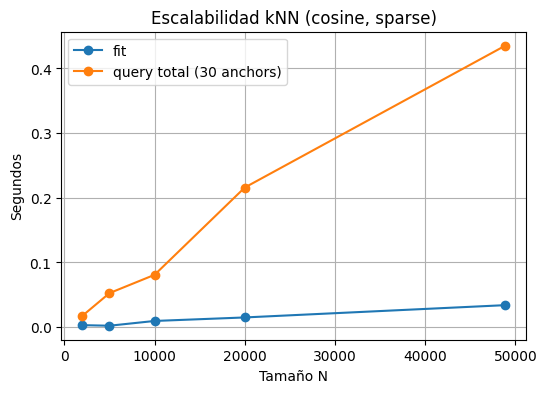

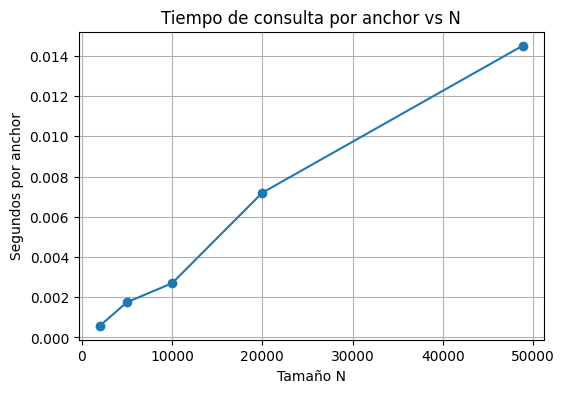


Tabla resumen:


,N,fit_seconds,query_seconds_total,query_seconds_per_anchor,memory_MB
0,2000,0.003000,0.017491,0.000583,1.637444
1,5000,0.002131,0.052558,0.001752,4.073536
2,10000,0.009494,0.080880,0.002696,8.030407
3,20000,0.014934,0.215892,0.007196,15.751030
4,48859,0.033942,0.435207,0.014507,39.259583


In [ ]:
# BENCHMARK DE ESCALABILIDAD 

import time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def _csr_bytes(csr):
    
    return (csr.data.nbytes + csr.indices.nbytes + csr.indptr.nbytes)

def benchmark_knn_scalability(df_feat, X,
                              Ns=(2000, 5000, 10000, 20000, None),
                              anchors_k=30, k_query=6,
                              algorithm='brute'):
    """
    Mide tiempo de fit y de consulta (kNN) para distintos tamaños N.
    - df_feat: dataframe con columna 'visits' para elegir anchors
    - X: matriz sparse (todas las filas)
    - Ns: lista de N. Usar None como 'usar todo'
    """
    results = []
    
    order_idx = df_feat.sort_values('visits', ascending=False).index.to_list()

    for N in Ns:
        N_eff = X.shape[0] if N is None else int(N)
        keep_idx = order_idx[:N_eff]
      
        pos = {idx:i for i, idx in enumerate(keep_idx)}

        XN = X[keep_idx]
       
        anchors_idx = keep_idx[:min(anchors_k, N_eff)]
        anchors_pos = [pos[i] for i in anchors_idx]

      
        t0 = time.perf_counter()
        nn = NearestNeighbors(metric='cosine', algorithm=algorithm, n_neighbors=min(k_query+1, N_eff))
        nn.fit(XN)
        fit_s = time.perf_counter() - t0

      
        t1 = time.perf_counter()
        _ = nn.kneighbors(XN[anchors_pos], n_neighbors=min(k_query+1, N_eff), return_distance=True)
        query_s = time.perf_counter() - t1

        mem_mb = _csr_bytes(XN) / (1024**2)
        results.append({
            'N': N_eff,
            'fit_seconds': fit_s,
            'query_seconds_total': query_s,
            'query_seconds_per_anchor': query_s / max(1, len(anchors_pos)),
            'memory_MB': mem_mb
        })
        print(f"N={N_eff:>7d} | fit={fit_s:6.3f}s | query_total={query_s:6.3f}s "
              f"| query/anchor={query_s/max(1,len(anchors_pos)):.4f}s | mem≈{mem_mb:,.1f} MB")

    return pd.DataFrame(results)


if 'df_feat' not in globals() or 'X' not in globals():
    BASE = globals().get('df_bq', None) or globals().get('df', None)
    assert BASE is not None and len(BASE) > 0, "Cargá tu DataFrame en df o df_bq"
    df_feat = prepare_features(BASE)
    df_feat = augment_features_extra(df_feat)
    X, _ = build_feature_matrix_flex(df_feat) 

Ns = (2000, 5000, 10000, 20000, None)  
bench = benchmark_knn_scalability(df_feat, X, Ns=Ns, anchors_k=30, k_query=6, algorithm='brute')


plt.figure(figsize=(6,4))
plt.plot(bench['N'], bench['fit_seconds'], marker='o', label='fit')
plt.plot(bench['N'], bench['query_seconds_total'], marker='o', label='query total (30 anchors)')
plt.xlabel('Tamaño N')
plt.ylabel('Segundos')
plt.title('Escalabilidad kNN (cosine, sparse)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(bench['N'], bench['query_seconds_per_anchor'], marker='o')
plt.xlabel('Tamaño N')
plt.ylabel('Segundos por anchor')
plt.title('Tiempo de consulta por anchor vs N')
plt.grid(True)
plt.show()

print("\nTabla resumen:")
display(bench)
